Prep work:

*   Download team csv predictions file
*   Rename files to team8-module2-predictions.csv where team8 is the name of your team
*   Make sure file is one column and remove any extra columns
*   Make sure the heading is set to "predictions" (without quotes)
*   Upload csv predictions to session storage area.
    *     Click the folder icon, then click the upload icon (paper with an upward arrow)
*   Run the notebook (Runtime -> Run all)






In [56]:
# MODULE 02 - BANK HOLDOUT GRADING

from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

blue_score = 650
orange_score = 300

# READ IN THE CSV FILES
team_dir = Path("./")
teams = team_dir.glob("*-predictions.csv")
team_list = []
for team in teams:
  # print(latent_file)
  team_list.append((str(team).split("-",1)[0],team))

# print(team_list)

In [57]:
# READ IN THE MINI HOLDOUT ANSWERS
targets_file = "https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bank_holdout_test_mini_answers.csv"
targets = pd.read_csv(targets_file)
# targets

In [58]:
# ARE THE STUDENT DATASETS THE CORRECT LENGTH
student_datasets = {}
for (group, file) in team_list:
  ds = pd.read_csv(file)

  if len(ds) != len(targets):
    print(f"Error group {group} ds had {len(ds)} rows instead of the expected {len(targets)}. It will be excluded.")
  else:
    student_datasets[group] = ds
    print(f"Group {group} added successfully")

Group team08 added successfully


In [59]:
# student_datasets

In [60]:
def recommended_grade(amount):
  '''
  A simple min max scaler to identify a recommended score for the holdout set
  '''
  min_allowed = orange_score
  max_allowed = blue_score
  if amount>max_allowed:
    return 100
  elif amount<min_allowed:
    return 0
  else:
    return (amount - min_allowed) / (max_allowed - min_allowed)*100


In [61]:
def value_of_calls(incorrect_calls, correct_calls):
  '''
  This function is based on assumptions about bank employee wages, time requirements,
  average savings amounts, and net interest margin. Wages, average savings, and net interest margin,
  were pulled from the time range of the dataset. Assumptions were made about time on call and the
  percentage of a person's total savings they'd be willing to put into a term deposit.
  '''
  time_on_call = .5
  wage = -11 # minimum wage is 6.50 and typicall teller wage is 11
  call_cost = wage*time_on_call
  average_savings = 4960
  percent_in_term_deposit = .75
  net_interest_margin = .012
  positive_call_benefit = average_savings*percent_in_term_deposit*net_interest_margin
  total_earned = incorrect_calls*call_cost + correct_calls*call_cost + correct_calls*positive_call_benefit
  return total_earned


In [62]:
results_dict = {}

In [63]:
for group, student_ds in student_datasets.items():
  student_dict = {}
  cm = confusion_matrix(student_ds, targets)
  # print(group,cm)
  student_dict["Incorrect Calls"] = cm[1][0]
  student_dict["Correct Calls"] = cm[1][1]
  student_dict["Value of Calls"] = value_of_calls(cm[1][0],cm[1][1])
  student_dict["Estimated Grade"] = recommended_grade(student_dict['Value of Calls'])

  results_dict[group] = student_dict

In [64]:
# results_dict

In [65]:
results_df = pd.DataFrame(results_dict)
results_ds_trans = results_df.transpose()
results_ds_trans = results_ds_trans.drop(columns=["Estimated Grade"])
results_ds_trans = results_ds_trans.round(2)
results_ds_trans = results_ds_trans.sort_values(by="Value of Calls",ascending=False)
# results_ds_trans.to_csv("class_results.csv")
# results_ds_trans

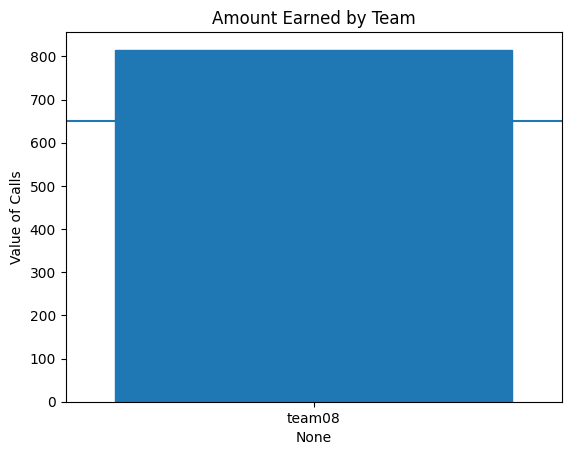

,Incorrect Calls,Correct Calls,Value of Calls
team08,51.0,28.0,815.42


In [66]:
# GENERATE GRAPHICS FOR TEAMS
# THESE CAN BE SHARED WITH THE STUDENTS

graph = sns.barplot(data=results_ds_trans,y="Value of Calls",x=results_ds_trans.index)
graph.set_title("Amount Earned by Team")
graph.axhline(blue_score)
for bar in graph.patches:
    if bar.get_height() > blue_score:
        bar.set_color('tab:blue')
    elif bar.get_height() <0:
      bar.set_color('tab:red')
    elif bar.get_height() < orange_score:
      bar.set_color('tab:orange')
    else:
        bar.set_color('tab:grey')
#The plot is shown
plt.show()
results_ds_trans